In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import warnings
warnings.filterwarnings('ignore')

## Read the csv

In [2]:
train = pd.read_csv('..\data/train.csv')
print("train.shape:", train.shape)
train.head()

train.shape: (50272, 2)


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [3]:
train['ImageId'] = train['ImageId_ClassId'].str[:-2]
train['ClassId'] = train['ImageId_ClassId'].str[-1:]
train['defect'] = train['EncodedPixels'].notnull()

train = train[['ImageId','ClassId','defect','EncodedPixels']]
train.head()

,ImageId,ClassId,defect,EncodedPixels
0,0002cc93b.jpg,1,True,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg,2,False,NaN
2,0002cc93b.jpg,3,False,NaN
3,0002cc93b.jpg,4,False,NaN
4,00031f466.jpg,1,False,NaN


## Task Objective
- Input: 1 image  
- Pred: an int with 5 classes (0/1/2/3/4) 0: no defect

## Tasks to Do
This notebook:  
1. [Csv preprocessing](#1)
2. [Plot a sample image with label](#2)  
3. [Image preprocessing](#3)

Next notebook
1. [Create a ImageLabelDataset, DataLoader using torch](#4)
2. [Model Architecture](#5)
3. [Training](#6)
4. [Eval](#7)

## 1. CSV Preprocessing<a class="anchor" id="1"></a>

### A) Training set

In [4]:
train = train.pivot(index='ImageId', columns='ClassId', values='EncodedPixels')
train = train.reset_index().rename_axis(None, axis=1)
train

,ImageId,1,2,3,4
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,NaN,NaN,NaN
1,00031f466.jpg,NaN,NaN,NaN,NaN
2,000418bfc.jpg,NaN,NaN,NaN,NaN
3,000789191.jpg,NaN,NaN,NaN,NaN
4,0007a71bf.jpg,NaN,NaN,18661 28 18863 82 19091 110 19347 110 19603 11...,NaN
...,...,...,...,...,...
12563,fff0295e1.jpg,NaN,NaN,NaN,NaN
12564,fff02e9c5.jpg,NaN,NaN,207523 3 207777 9 208030 15 208283 22 208537 2...,NaN
12565,fffe98443.jpg,NaN,NaN,105929 5 106177 14 106424 24 106672 33 106923 ...,NaN
12566,ffff4eaa8.jpg,NaN,NaN,16899 7 17155 20 17411 34 17667 47 17923 60 18...,NaN


In [5]:
train1 = train.copy()

train1.iloc[:, 1:] = train1.iloc[:, 1:].notnull()
train1


,ImageId,1,2,3,4
0,0002cc93b.jpg,True,False,False,False
1,00031f466.jpg,False,False,False,False
2,000418bfc.jpg,False,False,False,False
3,000789191.jpg,False,False,False,False
4,0007a71bf.jpg,False,False,True,False
...,...,...,...,...,...
12563,fff0295e1.jpg,False,False,False,False
12564,fff02e9c5.jpg,False,False,True,False
12565,fffe98443.jpg,False,False,True,False
12566,ffff4eaa8.jpg,False,False,True,False


In [6]:
train1['count'] = train1.iloc[:, 1:].apply(lambda x: sum(x), axis=1)
train1

,ImageId,1,2,3,4,count
0,0002cc93b.jpg,True,False,False,False,1
1,00031f466.jpg,False,False,False,False,0
2,000418bfc.jpg,False,False,False,False,0
3,000789191.jpg,False,False,False,False,0
4,0007a71bf.jpg,False,False,True,False,1
...,...,...,...,...,...,...
12563,fff0295e1.jpg,False,False,False,False,0
12564,fff02e9c5.jpg,False,False,True,False,1
12565,fffe98443.jpg,False,False,True,False,1
12566,ffff4eaa8.jpg,False,False,True,False,1


In [7]:
train1['count'].value_counts()

1    6239
0    5902
2     425
3       2
Name: count, dtype: int64

In [8]:
train1.iloc[:, :-1].to_csv('..\data/train_pivot.csv', index=False)

### B) Test set (sample_submission)

In [9]:
testset = pd.read_csv('..\data/sample_submission.csv')
testset

,ImageId_ClassId,EncodedPixels
0,004f40c73.jpg_1,1 1
1,004f40c73.jpg_2,1 1
2,004f40c73.jpg_3,1 1
3,004f40c73.jpg_4,1 1
4,006f39c41.jpg_1,1 1
...,...,...
7199,ffc9a6187.jpg_4,1 1
7200,ffdb60677.jpg_1,1 1
7201,ffdb60677.jpg_2,1 1
7202,ffdb60677.jpg_3,1 1


In [10]:
testset['ImageId'] = testset['ImageId_ClassId'].str[:-2]
testset['ClassId'] = testset['ImageId_ClassId'].str[-1:]
testset['defect'] = False

testset = testset[['ImageId','ClassId', 'defect']]
testset.head()

,ImageId,ClassId,defect
0,004f40c73.jpg,1,False
1,004f40c73.jpg,2,False
2,004f40c73.jpg,3,False
3,004f40c73.jpg,4,False
4,006f39c41.jpg,1,False


In [11]:
testset = testset.pivot(index='ImageId', columns='ClassId', values='defect')
testset = testset.reset_index().rename_axis(None, axis=1)
testset

,ImageId,1,2,3,4
0,004f40c73.jpg,False,False,False,False
1,006f39c41.jpg,False,False,False,False
2,00b7fb703.jpg,False,False,False,False
3,00bbcd9af.jpg,False,False,False,False
4,0108ce457.jpg,False,False,False,False
...,...,...,...,...,...
1796,ffa10f6f3.jpg,False,False,False,False
1797,ffaf13d96.jpg,False,False,False,False
1798,ffbf79783.jpg,False,False,False,False
1799,ffc9a6187.jpg,False,False,False,False


## 2. Plot a sample image with label<a class="anchor" id="2"></a>

In [12]:
# Extract the indices of 1/2/3/4 class defect for next step
idx_list = []
for i in range(4):
    idx = np.array(train1.index[train1[str(i+1)]==True].tolist())
    idx_list.append(idx)
    print(f"No. of class {i+1} defect: {len(idx_list[i])}")


No. of class 1 defect: 897
No. of class 2 defect: 247
No. of class 3 defect: 5150
No. of class 4 defect: 801


In [16]:
def rle2mask(rle, imgshape = (256,1600)):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

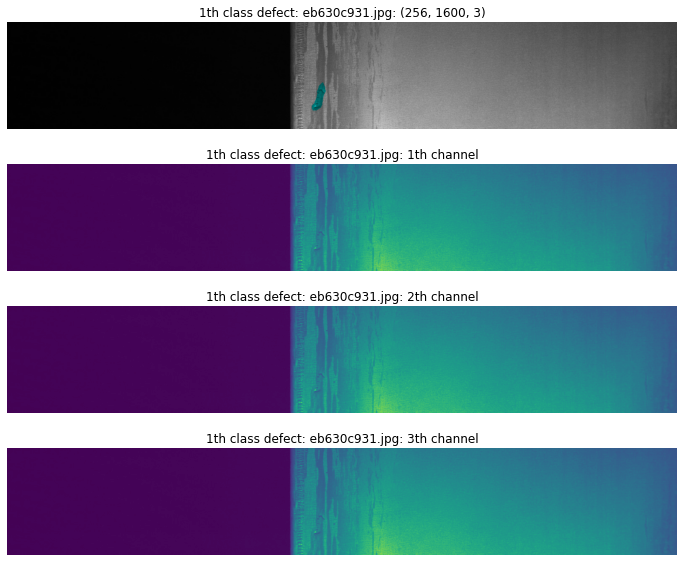

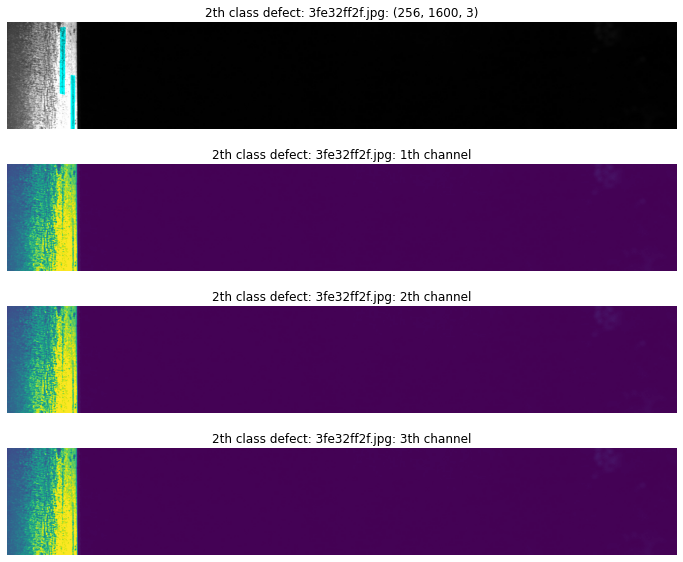

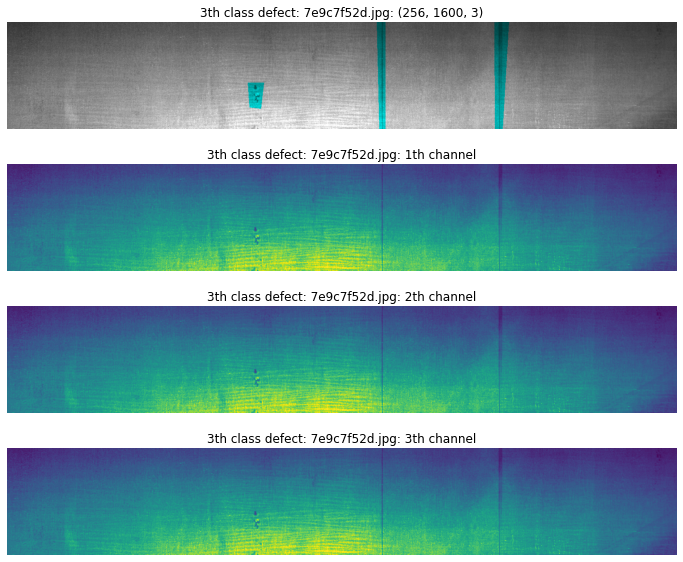

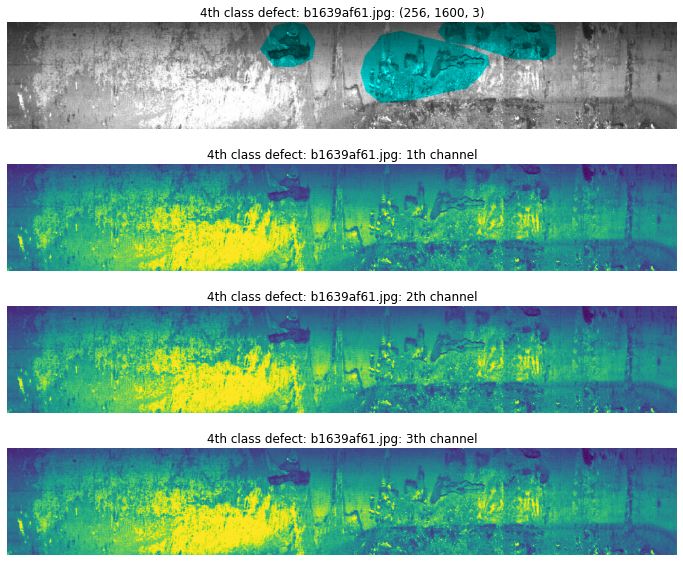

In [17]:
# Randomly show a sample from each class defect
np.random.seed(1999)

for cls in range(4):
    n = np.random.choice(idx_list[cls], replace=False)

    root_dir = '..\data/train_images/'
    filename = train['ImageId'].iloc[n]

    path = os.path.join(root_dir, filename)
    sample = cv2.imread(path)

    fig, axs = plt.subplots(4,1, figsize=(12,10))
    for i, ax in enumerate(axs):
        if i==0:
            mask = rle2mask(train[str(cls+1)].iloc[n])    
            sample1 = sample.copy()
            sample1[mask==1,0] = -255   #mask color   #put mask onto img
            ax.set_title(f"{cls+1}th class defect: {train['ImageId'].iloc[n]}: {sample.shape}")
            ax.axis('off')
            ax.imshow(sample1)
        else:
            ax.set_title(f"{cls+1}th class defect: {train['ImageId'].iloc[n]}: {i}th channel")
            ax.axis('off')
            ax.imshow(sample[:,:,i-1])


Seem like 3 channels are similar. Maybe we may just take a avg on 3 channels (pixel-wise avg).

## 3. Image preprocessing<a class="anchor" id="3"></a>
Objective: To explore what image preprocessing may benefit to the model?  
- **pixel-wise avg? (gray scale) Yes**
- just take one channel? Yes, same as grayscale
- crop/padding? No
- **rotation? Yes**
- Resize to square? No 
- **normalise? (/255) Yes**

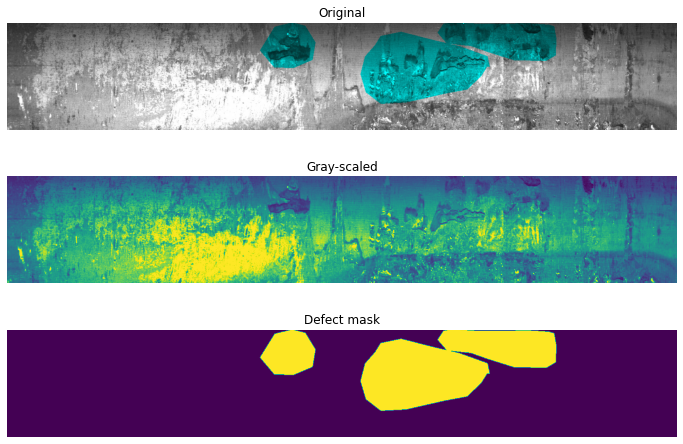

In [18]:
IMG_SIZE = 256

# pixel-wise avg (To gray scale)
gray_image = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)   #same as sum(3 channels)/3   # (sample[:,:,0].astype(int) + sample[:,:,1] + sample[:,:,2].astype(int))/3

# normalise
gray_image = gray_image.astype(np.float32)/255

fig, axs = plt.subplots(3,1, figsize=(12,8))
axs[0].set_title("Original")
axs[0].axis('off')
axs[0].imshow(sample1)

axs[1].set_title("Gray-scaled")
axs[1].axis('off')
axs[1].imshow(gray_image)

axs[2].set_title("Defect mask")
axs[2].axis('off')
axs[2].imshow(mask)

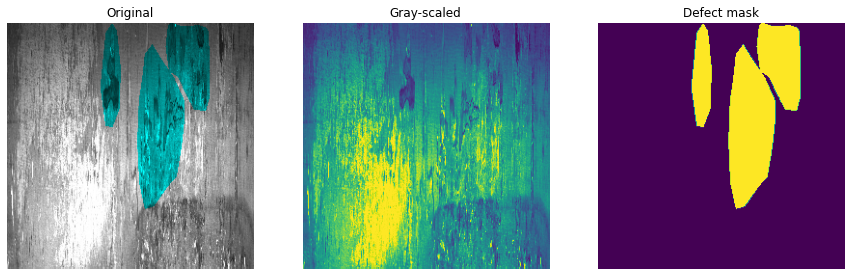

In [19]:
# Resize (the square image seems not good)

IMG_SIZE = 256

# pixel-wise avg (To gray scale)
gray_image = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)   #same as sum(3 channels)/3   # (sample[:,:,0].astype(int) + sample[:,:,1] + sample[:,:,2].astype(int))/3

# normalise
gray_image = gray_image.astype(np.float32)/255

fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].set_title("Original")
axs[0].axis('off')
axs[0].imshow(cv2.resize(sample1, (IMG_SIZE, IMG_SIZE)))

axs[1].set_title("Gray-scaled")
axs[1].axis('off')
axs[1].imshow(cv2.resize(gray_image, (IMG_SIZE, IMG_SIZE)))

axs[2].set_title("Defect mask")
axs[2].axis('off')
axs[2].imshow(cv2.resize(mask, (IMG_SIZE, IMG_SIZE)))

In the next notebook, we will start implement 1)dataset, 2)dataloader, 3)model, 4)eval using the output csv (train_pivot.csv)